In [539]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from scipy.linalg import eig
import time
from copy import deepcopy
import scipy.stats as stats
import networkx as nx
from networkx import Graph, DiGraph
import seaborn as sns
from matplotlib.colors import ListedColormap

# TODO
* Generate Random Networks
    * ~~Fully connected network generation~~
    * ~~Aperiodic network generation~~
    * ~~Adjust probability of self link~~
    * ~~Ability to incrase wieghts of agents above bare minimum~~
        * ~~Favour earlier agents when increasing degree~~
    * ~~Growing instantly from an already existing network~~
    * Possibility of changing probability distribution of increased degree
    * ~~Undirected networks~~
    * Non-uniform weights
    * More specific network structures
    * Non-cooperative agents
        * Not actually part of the network to preserve connectedness
        * Through chance
            * Tracking list of non-cooperative agents to ensure they do not impact connectedness
        * Set amount, determined by network size/user input
            * Tracking list of non-cooperative agents to ensure they do not impact connectedness
            * Tracking may not be necessary to implement
        * Deviation from truth
    * Different probability distributions of initial belief
    
* Implement Updating Variations
    * Implement convergence
    * DeGroot
    * Private Belief
    * $\varepsilon$-DeGroot
    * Time-dependent weights
    
* Optional possibilities to look into:
    * non-constant bots, giving a periodic influence to the beliefs of agents
    * negative weights

In [4]:
IMAGE_PATH = "ThesisKI/Images/"

In [655]:
class Network():
    def __init__(self, p_selflink=1, n_agents=1000, directed="True", uniform="True", increase_degree=True):
        self.truth = random.uniform(0,1)
        self.p_selflink = p_selflink
        self.weights = self.grow_network_instant(n_agents=n_agents, directed=directed,
                                                 increase_degree=increase_degree)
        #self.agent_degree_distribution(n_agents=1000, averaging_step=100, comparison=True)
        #self.speed_test(n_agents=1000, increase_degree=False)
        #self.degree_distribution(n_agents, directed=False)
        self.draw_network(self.weights, directed=directed, layout_function=nx.random_layout,
                          cmap_var="degree", show_nodes=True, save_figure=True)
    
    """
    Functional functions.
    Up-to-date and work as intended.
    """
    
    # PLOTTING FUNCTIONS
    
    # Functional
    def degree_distribution(self, n_agents, save_image=False, save_path=IMAGE_PATH, 
                            show_plot=True, save_extension=".png", directed=True,
                            prob_func_degree=np.random.normal, prob_func_degree_param=[2,1]):
        """
        Generates networks with n_agents to plot the degree distribution of said network.
        Compares the difference between the standard degree distribution and the degree
        distribution when additional links are generated for each network.
        
        Input:
            n_agents: int, number of agents the generated network will have.
            save_image: bool, default=False, whether the generated plots should
                be saved.
            save_path: string, default=IMAGE_PATH, the path to wich the images
                should be saved.
            show_plot: bool, default=True, whether the generated plots are shown.
            save_extension: string, default=.png, extension, should the plot be saved.
        """
        
        # Generate a network with increased degree and with standard degree
        network_instant_increase = self.grow_network_instant(n_agents=n_agents, directed=directed,
                                                             increase_degree=True, 
                                                             prob_func_degree=prob_func_degree,
                                                             prob_func_degree_param=prob_func_degree_param)
        network_instant = self.grow_network_instant(n_agents=n_agents, increase_degree=False, 
                                                    directed=directed, prob_func_degree=prob_func_degree,
                                                    prob_func_degree_param=prob_func_degree_param)

        # Compute the in- and out-degree of both networks
        instant_in_degree_increase = np.count_nonzero(network_instant_increase, axis=1)
        instant_out_degree_increase = np.count_nonzero(network_instant_increase, axis=0)
        instant_in_degree = np.count_nonzero(network_instant, axis=1)
        instant_out_degree = np.count_nonzero(network_instant, axis=0)
        
                    
        # Generate the subplots for the histograms
        
        if directed:
            fig, axs = plt.subplots(2,2, sharey=True)
            fig.set_size_inches(7.5, 5)
            save_name = "DegreeDirected"
            fig.suptitle(f"Directed Degree Distribution, n={n_agents}")
            # Number of bins is set to the max of the degree, s.t. each bin equals one
            axs[0, 0].hist(instant_out_degree, edgecolor="slategrey", 
                           color="skyblue", bins=np.amax(instant_out_degree))
            axs[0, 0].set_title("Standard Out-egree")
            axs[0, 1].hist(instant_in_degree, edgecolor="slategrey",
                           color="skyblue", bins=np.amax(instant_in_degree))
            axs[0, 1].set_title("Standard In-degree")
            axs[1, 0].hist(instant_out_degree_increase, edgecolor="slategrey",
                           color="skyblue", bins=np.amax(instant_out_degree_increase))
            axs[1, 0].set_title("Increased Out-degree")
            axs[1, 1].hist(instant_in_degree_increase, edgecolor="slategrey",
                           color="skyblue", bins=np.amax(instant_in_degree_increase))
            axs[1, 1].set_title("Increased In-degree")
            
        else:
            fig, axs = plt.subplots(1,2, sharey=True)
            fig.set_size_inches(7.5, 5)
            save_name = "DegreeUndirected"
            fig.suptitle(f"Undirected Degree Distribution, n={n_agents}")
            # Number of bins is set to the max of the degree, s.t. each bin equals one
            axs[0].hist(instant_out_degree, edgecolor="slategrey", 
                           color="skyblue", bins=np.amax(instant_out_degree))
            axs[0].set_title("Standard Degree")
            axs[1].hist(instant_in_degree_increase, edgecolor="slategrey",
                           color="skyblue", bins=np.amax(instant_in_degree_increase))
            axs[1].set_title("Increased Degree")

        fig.tight_layout()
        if save_image:
            plt.savefig(IMAGE_PATH+save_name+save_extension)
        if show_plot:
            plt.show()
    
    # Functional
    def agent_degree_distribution(self, n_agents=30, increase_degree=False, directed=True,
                                  comparison=False, save_image=False, save_path=IMAGE_PATH,
                                  show_plot=True, averaging_step=1, save_extension=".png",
                                  prob_func_degree=np.random.normal, prob_func_degree_param=[2,1]):
        
        """
        Creates barplots of the agents degree. 
        The degree is then averaged over every averaging_step agents, 
        to ensure a readable resolution of the barplot.
        
        Input:
            n_agents: int, number of agents the generated network will have.
            increase_degree: bool, whether the agents should receive additional links.
            comparison: bool, whether to compare the increased degree and standard degree.
            save_image: bool, default=False, whether the generated plots should
                be saved.
            save_path: string, default=IMAGE_PATH, the path to wich the images
                should be saved.
            show_plot: bool, default=True, whether the generated plots are shown.
            instant: bool, default=True, whether the instant generation method 
                should be used.
            averaging_step: int, default=1, the amount of agents a bin should represent, meaning
                the amount of agents the degree will be averaged over.
            save_extension: string, default=.png, extension, should the plot be saved.
        """
        
        # Create the x-axis
        x = [i+1 for i in range(int(n_agents/averaging_step))]
        # Create an array to use in the averaging of the degrees.
        # Needs to have the same size as x
        avg = np.arange(n_agents)//averaging_step
        
        # Title of the plot
        title = f"Degree Distribution, Per Agent \n n={n_agents}, 1 Bin Is Mean Of {averaging_step}"
        
        if not comparison:
            if increase_degree:
                title = "Increased " + title
                save_name = "IncreasedPerAgent"
            else:
                title = "Standard " + title
                save_name = "StandardPerAgent"
                
            # Generate the network
            network = self.grow_network_instant(n_agents, increase_degree=increase_degree, 
                                                directed=directed, prob_func_degree=prob_func_degree)
                
            # Get in and out degree of network
            in_degree = np.count_nonzero(network, axis=1)
            out_degree = np.count_nonzero(network, axis=0)
            
            # Average the degrees over the bins to ensure readable resolution in the plot
            in_degree_avg = np.bincount(avg, out_degree)/np.bincount(avg)
            out_degree_avg = np.bincount(avg, in_degree)/np.bincount(avg)
            
            # Create plots for directed network
            if directed:
                title = "Directed " + title
                save_name = "Directed" + save_name
                # Create the specifics of the subplots
                fig, axs = plt.subplots(1, 2, sharey=True)
                fig.suptitle(title)
                axs[0].bar(x=x, height=out_degree_avg, color="skyblue")
                axs[0].set_title("Out-degree per agent")
                axs[1].bar(x=x, height=in_degree_avg, color="skyblue")
                axs[1].set_title("In-degree per agent")

                fig.tight_layout()
                for ax in axs.flat:
                    xlabel = "Agents"
                    ylabel = "Degree"
                    ax.set(xlabel=xlabel, ylabel=ylabel)
                    
            else:
                title = "Undirected " + title
                save_name = "Undirected" + save_name
                plt.bar(x, in_degree_avg, color="skyblue")
                plt.xlabel("Agent")
                plt.ylabel("Degree")
            
        else:
            # Generate two networks, with both increased degree and standard degree
            # Then creates a subplot comparing them
            save_name = "ComparisonPerAgent"
            
            # Generate two networks
            network = self.grow_network_instant(n_agents, increase_degree=False)
            network_increase = self.grow_network_instant(n_agents, increase_degree=True)
            
            # Compute & average standard degrees
            in_degree_std = np.count_nonzero(network, axis=1)
            out_degree_std = np.count_nonzero(network, axis=0)            
            in_degree_std_avg = np.bincount(avg, out_degree_std)/np.bincount(avg)
            out_degree_std_avg = np.bincount(avg, in_degree_std)/np.bincount(avg)
            
            # Compute & average increased degrees
            in_degree_inc = np.count_nonzero(network_increase, axis=1)
            out_degree_inc = np.count_nonzero(network_increase, axis=0)            
            in_degree_inc_avg = np.bincount(avg, out_degree_inc)/np.bincount(avg)
            out_degree_inc_avg = np.bincount(avg, in_degree_inc)/np.bincount(avg)            
            
            if directed:
                title = "Directed " + title
                save_name = "Directed" + save_name
                # Create specifics of subplots
                fig, axs = plt.subplots(2, 2, sharey=True)
                fig.suptitle(title)
                axs[0, 0].bar(x=x, height=out_degree_std_avg, color="skyblue")
                axs[0, 0].set_title("Standard Out-degree")
                axs[0, 1].bar(x=x, height=in_degree_std_avg, color="skyblue")
                axs[0, 1].set_title("Standard In-degree")

                axs[1, 0].bar(x=x, height=out_degree_inc_avg, color="coral")
                axs[1, 0].set_title("Increased Out-degree")
                axs[1, 1].bar(x=x, height=in_degree_inc_avg, color="coral")
                axs[1, 1].set_title("Increased In-degree")
                fig.tight_layout()
                for ax in axs.flat:
                    xlabel = "Agent"
                    ax.set(xlabel=xlabel, ylabel="Degree")
                    
            else:
                title = "Directed " + title
                save_name = "Directed" + save_name
                # Create the specifics of the subplots
                fig, axs = plt.subplots(1, 2, sharey=True)
                fig.suptitle(title)
                axs[0].bar(x=x, height=in_degree_std_avg, color="skyblue")
                axs[0].set_title("Standard degree per agent")
                axs[1].bar(x=x, height=in_degree_inc_avg, color="coral")
                axs[1].set_title("Increased degree per agent")

                fig.tight_layout()
                for ax in axs.flat:
                    xlabel = "Agents"
                    ylabel = "Degree"
                    ax.set(xlabel=xlabel, ylabel=ylabel)
        if directed or comparison:  
            for ax in fig.get_axes():
                ax.label_outer()
        
        if save_image:
            plt.savefig(IMAGE_PATH+save_name+save_extension)
        if show_plot:
            plt.show()
    
    # Functional
    def speed_test(self, n_agents, save_image=False, save_path=IMAGE_PATH, save_extension=".png",
                   show_plot=True, iterations=10, step_size=.1, increase_degree=False):
        """
        Compare the time to generate networks of up to n_agents using the 
        different generation methods, averaged over a given number of iterations.
        
        Input:
            n_agents: int, upper bound of network size.
            save_image: bool, default=False, whether the plot should be saved.
            save_path: string, default=IMAGE_PATH, the path to which the plot 
                should be saved.
            show_plot: bool, default=True, whether the plot should be shown.
            iterations: int, default=10, over how many iterations the time
                will be averaged.
            step_size: float, default=.1, used to indicate step size for generating
                the models, given by int(step_size*n_agents).
            save_extension = string, default=.png, extension, should the plot be saved.
        """
        
        instant = []
        for k in tqdm(range(iterations)):
            instant_time = []
            sizes = []
            # Generate models of up to n_agents, increasing by step_size
            for i in range(0, n_agents+1, int(step_size*n_agents)):
                sizes.append(i)
                # Timing of instant generation of network
                t_start = time.perf_counter()
                network_instant = self.grow_network_instant(n_agents=i, increase_degree=increase_degree)                
                t_end = time.perf_counter()
                # Compute passed time in ms
                instant_time.append((t_end-t_start)*1000)
                
            instant.append(instant_time)          
        
        # Generate plots for the measurements
        plt.plot(sizes, np.mean(np.array(instant), axis=0), label="Instant", color="skyblue")
        plt.legend()
        plt.xlabel("Number of agents in network")
        plt.ylabel("Generation time (ms)")
        plt.title("Network generation time vs. agents")
        if save_image:
            plt.savefig(IMAGE_PATH+"GenTime2"+save_extension)
        if show_plot:
            plt.show()        
    
    # NETWORK GROWING FUNCTIONS
    
    # Functional
    def normalize_weights(self, weights):
        """
        Generates a stochastic adjacency matrix 
        based on the weight matrix.
        
        Input:
            weights: np.array, network weight matrix
        Output:
            stochastic weight matrix.
        """
        return weights/weights.sum(1)[:, np.newaxis]    
    
    # Functional
    def grow_network_instant(self, n_agents, increase_degree=False, weights=None, directed=True,
                             prob_func_degree = np.random.normal, prob_func_degree_param=[2, 1]):
        """
        Creates a network of size n_agents x n_agents.
        If an existing network is passed to the function it grows this network by n_agents.
        
        Input:
            n_agents: int, number of agents by which the network should be grown
            increase_degree: bool, default=False, whether each agent should be generated
                with more than the minimum guaranteed links.
            p_selflink: float <=1, the probability that an agent forms a link with itself.
            weights: np.array, default=None, a pre-existing network to grow.
            directed: bool, default=True, whether the links in the network are directed or not.
            prob_func_degree: np.random probability distribution, default=np.random.normal,
                determines which probability distriubtion is used for determining the increased degree.
            prob_func_degree_param: iterable, default=[2,1], parameters to be used for the probability
                distribution of the increased degree.
        Output:
            network: np.array, size n_agents x n_agents representing the network.
        """
        # If no existing array is giving make a new one
        if weights == None:            
            weights = np.zeros((n_agents, n_agents))
            growth_step = n_agents
        # Grow the existing array by n_agents
        else:
            weights = np.concatenate((weights, np.zeros((n_agents, weights.shape[1]))), axis=0)
            weights = np.concatenate((weights, np.zeros((weights.shape[0], n_agents))), axis=1)
            growth_step = n_agents
            n_agents = weights.shape[0]
        
        # Create the links in the network
        for i in range(growth_step):
            # Ensure first agent receives a self loop to ensure aperiodicity
            if i == 0:
                weights[0,0] = 1
                continue
            else:
                # Establish connections for agent i, if it is a directed network two
                # random agent will be chosen, independently, if it is undirected
                # one agent is chosen to both receive and send a link to i.
                neighbour = np.random.randint(i) # Determine which agent listens to i
                weights[neighbour, i] = 1 # Outgoing link
                
                # If the network is directed choose a new neighbour to receive i's
                # incoming links.
                if directed:
                    neighbour = np.random.randint(i) # Determine to which agent i listens                  
                weights[i, neighbour] = 1 # Incoming link

                # Determine whether the agent has a self link
                if random.uniform(0,1) <= self.p_selflink:
                    weights[i,i] = 1
            
            # Increase the degree of the agent.
            if increase_degree:                
                # Determine the additional degree of the agent and
                # add the corresponding amount of links
                if type(prob_func_degree(*prob_func_degree_param)) != float:
                    add_degree = int(round(prob_func_degree(*prob_func_degree_param)[0]))
                else:
                    add_degree = int(round(prob_func_degree(*prob_func_degree_param)))
                if add_degree > 0:
                    # Choose an amount of random neighbours equal to the additional degree.
                    add_neighbours = np.random.randint(0, n_agents, add_degree)
                    weights[add_neighbours, i] = 1 # Outgoing links
                    if not directed:
                        weights[i, add_neighbours] = 1 # Incoming links
                        continue
                # If the network is directed generate a new, random, amount of
                # outgoing links, and the corresponding neighbours.
                if type(prob_func_degree(*prob_func_degree_param)) == np.ndarray:
                    add_degree = int(round(prob_func_degree(*prob_func_degree_param)[0]))
                else:
                    add_degree = int(round(prob_func_degree(*prob_func_degree_param)))
                if add_degree > 0:
                    add_neighbours = np.random.randint(0, n_agents, add_degree)
                    weights[i, add_neighbours] = 1 # Incoming links
                
        return weights
    
    # Functional
    def grow_beliefs(self, n_agents, truth, beliefs=None):
        """
        Grows or generates the belief vector for n_agents.
        If an existing belief vector is passed to the function
        this vector is grown by an additional n_agents.
        The belief is a random normally distributed number on
        the interval [0, 1] with mean=truth, and sd=truth**2
        
        Input:
            n_agents: int, size of the generated vector, or
                number of agents by which it is grown if a
                vector is passed to the function.
            truth: float, <=1, the truth value of the model, used to
                determine the mean and sd of the distribution.
        Output:
            np.array, size n_agents, containing the beliefs.
        """
        
        
        if beliefs != None:
            n_agents+=beliefs.shape[0]
            
        return np.random.normal(truth, .5, n_agents)    
    
    """
    WIP Functions
    """
    
    def draw_network(self, weights, save_figure=False, save_extension=".png", cmap_var=None,
                     layout_function=nx.kamada_kawai_layout, directed=True, save_name="Graph",
                     show_edges=True, show_nodes=True):
        """
        Used to draw a graph based on a given weight matrix.
        Colours the nodes of the cmap based on their value of a given property.
        Input:
            weights: np.array, adjacency matrix of the network.
            save_figure: bool, default=False, whether the figure should be saved.
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            layout_function: networkx layout function, default=nx.kamada_kawai,
                function used to determine the layout of the graph.
            directed: bool, default=False, whether to represent the network as a
                directed or undirected graph.
            save_name: string, default=graph, name of the saved figure.
            cmap_var: string, default=None, what attribute to label the nodes with
                for the cmap, can be difference from truth, degree, degree as fraction
                of total degree, etc. If None al nodes are given the same colour.
            show_edges: bool, default=True, whether the edges should be shown.
            show_nodes: bool, default=True, whether the nodes should be shown.
        """
        
        # Get beliefs
        values = self.grow_beliefs(weights.shape[0], self.truth)
        # Get difference between truth and beliefs
        cmap_values = np.abs(values-self.truth)
        
        in_degree = np.count_nonzero(weights, axis=1)
        in_degree_frac = in_degree/weights.shape[0]
        out_degree = np.count_nonzero(weights, axis=0)
        out_degree_frac = out_degree/weights.shape[0]
        
        
        cmap_dict = {"degree":(in_degree, np.amin(in_degree), np.amax(in_degree)),
                     "degree_frac":(in_degree_frac, 0, 1),
                     "indegree":(in_degree, np.amin(in_degree), np.amax(in_degree)),
                     "indegree_frac":(in_degree_frac, np.amin(in_degree_frac), 
                                       np.amax(in_degree_frac)),
                     "outdegree":(in_degree, np.amin(in_degree), np.amax(in_degree)),
                     "outdegree_frac":(out_degree_frac, np.amin(out_degree_frac), 
                                        np.amax(out_degree_frac)),
                     "truth":(cmap_values, 0, 1),
                     None: ("skyblue", 0, 1)
                    }
        if cmap_var is not None:
            save_name = cmap_var[0].upper()+cmap_var[1:] + save_name
        cmap, vmin, vmax = cmap_dict[cmap_var]
        
        # Get graph from adjacency matrix
        if directed:
            arrows = True
            graph = nx.convert_matrix.from_numpy_array(weights, create_using=DiGraph)
        else:
            arrows = False
            graph = nx.convert_matrix.from_numpy_array(weights)
        # Link opinions to values
        value_dict = {node:value for node, value in zip(graph.nodes, cmap_values)}
        nx.set_node_attributes(graph, values=value_dict, name="x")
        
        # graph.nodes[0]["x"]
        
        # Create the figure
        f = plt.figure(1)
        f.set_size_inches(15, 10)
        ax = f.add_subplot(1,1,1)
        # Turn off the axis to prevent a box around the drawing
        ax.axis("off")
        ax.set_title(f"Social Network labeled by {cmap_var}")
        # Get the layout of the nodes and edges
        pos = nx.kamada_kawai_layout(graph)
        if show_nodes:
            # Draw the nodes, with a color map applied to the differing beliefs
            nodes = nx.draw_networkx_nodes(graph, pos, node_color=cmap, alpha=.75, 
                                           cmap=plt.get_cmap("viridis"), vmin=vmin, vmax=vmax, ax=ax)
        if show_edges:
            # Draw the edges
            edges = nx.draw_networkx_edges(graph, pos, alpha=.75, ax=ax, arrows=arrows)
        # Specify the color mapping
        if cmap_var is not None and show_nodes:
            sm = plt.cm.ScalarMappable(cmap=sns.color_palette("viridis", as_cmap=True),
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
            sm._A = []
            # Draw the color bar
            plt.colorbar(sm, label=cmap_var)
        if save_figure:
            plt.savefig(IMAGE_PATH+"test"+save_extension)
            print(f"FIGURE STORED IN {IMAGE_PATH[:-1]} as {save_name+save_extension}")
    
    """
    Outdated functions.
    Need to be updated to work with the latest versions.
    """
    
    # Outdated
    def converge_network(self, T):
        """
        Converges the current network.
        Returns the amount of iterations required for convergence
        
        Output:
            counter: int, the step t at which the network converges
        """
        counter = 0
        prev_T = np.zeros(T.shape)
        while (prev_T - T).sum() != 0:
            prev_T = T
            T = T @ self.T
            counter+=1
        return counter-1
    
    # Outdated, probably not functional
    def test_to_wisdom(self, n_agents):
        # Create network
        self.weights, self.beliefs = self.grow_network_instant(n_agents)
        convergence_times = []
        
        # Get time to converge for each n
        for i in range(n_agents):
            # Get stochastic matrix from weights matrix
            T = normalize_weights(self.weights[:i+1, :i+1])
            # Converge network and save the time
            t_to_convergence = self.converge_network(T)
            convergence_times.append(t_to_convergence)
            
            # Check if network is wise
            if (T@np.array(self.beliefs)[:i+1])[0] == self.truth:
                # Number of agents at which the network became wise
                return i+1, convergence_times
        else:
            # If the initial size of the network was not sufficient
            # to attain wisdom grow it incrementally until it does
            while (T@np.array(self.beliefs))[0] != self.truth:
                # Grow network, beliefs, and normalize the weights
                self.weights = self.grow_network_concat(self.weights)
                T = self.normalize_weights(self.weights)
                self.beliefs = self.grow_beliefs(self.beliefs)
                
                # Converge the network
                t_to_convergence = self.converge_network(T)
                convergence_times.append(t_to_convergence)
                
        return self.beliefs.shape[0]+1, converge_times
    
    
    """
    Unnecessary functions.
    No need to be updated, saved for safety,
    need to be removed at the end.
    """
    
    # Unnecessary -- No need to update
    def gen_t0(self):
        """
        Only for use with incremental growing.
        No longer necessary
        """
        # First agent always has a self link to ensure aperiodicity
        adjacency = np.ones((1,1))
        return adjacency
    
    # Unnecessary -- No need to update
    def grow_network_concat(self, weights):
        """
        Grows the existing network by 1 agent.
        Creates links between this agent and the existing agents in the network.
        
        Input:
            weights: square np.array, the network at its current size.
            p_selflink: float <=1, the probability that an agent forms
                a link with itself.
        Output:
            np.array, the inut network grown by one agent.        
        """
        
        # Grow network by one agent by concatenating a row and column of zeroes
        weights = np.concatenate((weights, np.zeros((1, weights.shape[1]))), axis=0)
        weights = np.concatenate((weights, np.zeros((weights.shape[0], 1))), axis=1)
        
        # Determine randomly if a self-link should be generated
        if random.uniform(0,1) <= self.p_selflink:
            weights[weights.shape[0]-1, weights.shape[1]-1] = 1
        
        # Create connections with the new agents in the network
        # Always at least one incoming and outgoing link, to guarantee strong connectedness
        out_agent = np.random.randint(weights.shape[0]-1)
        in_agent = np.random.randint(weights.shape[0]-1)        
        weights[weights.shape[0]-1, in_agent] = 1
        weights[out_agent, weights.shape[1]-1] = 1
        
        return weights
    
    # Unnecessary -- No need to update
    def grow_network_inc(self, n_agents, increase_degree=False):
        weights = self.gen_t0()
        
        for i in range(n_agents-1):
            weights = self.grow_network_concat(weights)
        
        if increase_degree:
            for i in range(n_agents):
                # Determine the additional in- and out-degree
                add_in_degree = int(np.floor(np.random.normal(2, 1)))
                add_out_degree = int(np.floor(np.random.normal(2, 1)))
                
                # Ensure only agents with a positive additional degree
                # will receive additional links
                if add_out_degree > 0:
                    for _ in range(add_in_degree):
                        j = np.random.randint(0, n_agents)
                        weights[j, i] = 1

                if add_in_degree > 0:
                    for _ in range(add_out_degree):
                        j = np.random.randint(0, n_agents)
                        weights[i, j] = 1
                        
        return weights
    
    # Unnecessary -- No need to update
    def gen_signal(self):
        """
        Generate the initial signal that an agent receives
        """
        return np.random.normal(self.truth, self.truth**2)

FIGURE STORED IN ThesisKI/Images as DegreeGraph.png


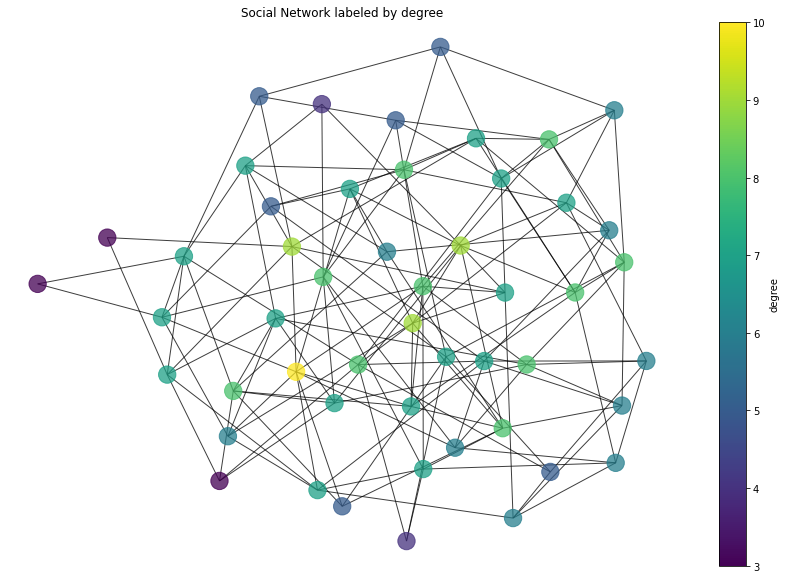

In [656]:
#plt.rcParams.update({'font.size': 10})
NetworkVar = Network(n_agents=50, increase_degree=True, directed=False)

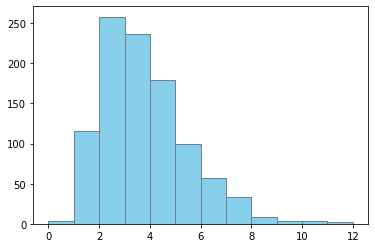

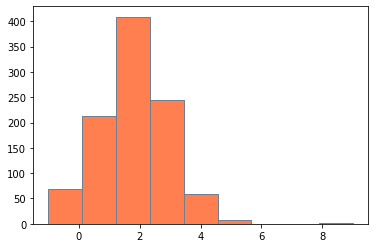

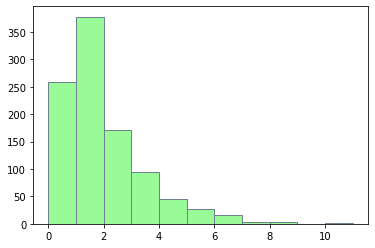

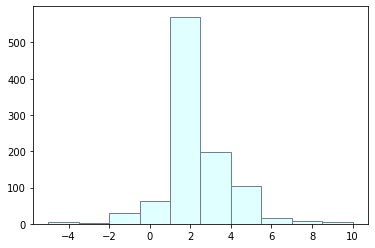

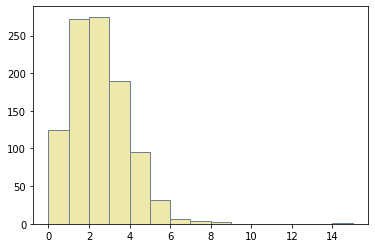

Hallo


In [645]:
def test_prob_functions(iterations=1000, *args):
    funcs = args[0]
    params = args[1]
    
    p_func_outcomes = []
    for p_func, param in zip(funcs, params):
        for i in range(iterations):
            outcome = p_func(*param)
            if type(outcome) != float:
                outcome = outcome[0]
            if i ==3:
                outcome=3*outcome
            outcome = int(round(outcome))
            p_func_outcomes.append(outcome)
            
    plt.hist(p_func_outcomes[:iterations], bins=np.amax(p_func_outcomes[:iterations]), 
             color="skyblue", label="gamma", edgecolor="slategrey")
    plt.show()
    plt.hist(p_func_outcomes[iterations:2*iterations], bins=np.amax(p_func_outcomes[iterations:2*iterations]), 
             color="coral", label="normal", edgecolor="slategrey")
    plt.show()
    plt.hist(p_func_outcomes[2*iterations:3*iterations], bins=np.amax(p_func_outcomes[2*iterations:3*iterations]), 
             color="palegreen", label="exponential", edgecolor="slategrey")    
    plt.show()
    plt.hist(p_func_outcomes[3*iterations:4*iterations], bins=np.amax(p_func_outcomes[3*iterations:4*iterations]), 
             color="lightcyan", label="laplace", edgecolor="slategrey")    
    plt.show()
    plt.hist(p_func_outcomes[4*iterations:], bins=np.amax(p_func_outcomes[4*iterations:]), 
             color="palegoldenrod", label="poisson", edgecolor="slategrey")    
    plt.show()
    return
prob_funcs = [np.random.gamma, np.random.normal, np.random.exponential, 
              np.random.laplace, np.random.poisson]
prob_params = ((4, .8), (2, 1), (1.5,1), (2, 1), (2, 1))

test_prob_functions(1000, prob_funcs, prob_params)
sns.light_palette("seagreen", as_cmap=True)
tst = "hallo"
print(tst[0].upper()+tst[1:])